In [44]:
import os
import sys
import numpy as np
import scipy
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

## ten-armed bandit test-bed
This is an implementation of the 10-armed bandit testbed from Sutton & Barto pp 28...

In particular, we do epsilon greedy on a 10 armed bandit with random reward distributions.

In [123]:
K = 10
epsilon = 0.1
num_timesteps = 1000
num_runs = 1000  # We'll do 1/4 the number of runs... 

def get_rewards(K=10):
    """
    Return scipy random variables for each of K arms of a stationary bandit,
    along with ground truth expected rewards for each arm.
    """
    rewards = []
    means = np.random.normal(size=K)
    for k in range(K):
        rewards.append(
            scipy.stats.norm(loc=means[k], scale=1.)
        )
    return rewards, means

def do_run(K=10, epsilon, num_timesteps, init_value=0.):
    """
    Do a single run of num_timesteps using the suppied epsilon and initial estimate.
    Return observed rewards, along with choice at each time step, and reward at
    each timestep.
    """
    # Set up list of rewards for each arm.
    rewards = get_rewards(K=K)
    num_tries = np.zeros(K)
    estimates = np.array([init_value]  * K)

    reward_at_time = []
    choice_at_time = []
    
    for t in range(num_timesteps):
        # Get current highest estimate.
        max_estimate = np.max(estimates)
        if np.random.uniform() < epsilon:
            # Pick one of the non-optimal ones randomly.
            suboptimal_choices = np.where(estimates < max_estimate)[0]
            if len(suboptimal_choices) == 0:
                this_choice = np.random.choice(K)
            else:
                this_choice = np.random.choice(suboptimal_choices)
        else:
            optimal_choices = np.where(estimates == max_estimate)[0]
            this_choice = np.random.choice(optimal_choices)
        
        # Evaluate this choice
        this_reward = rewards[this_choice].rvs(1)
        
        # Update estimate for this choice.
        num_tries[this_choice] += 1
        estimates[this_choice] += (this_reward - estimates[this_choice]) / num_tries[this_choice]
        
        choice_at_time.append(this_choice)
        reward_at_time.append(this_reward)
        
    reward_at_time = np.squeeze(np.array(reward_at_time))
    choice_at_time = np.squeeze(np.array(choice_at_time))
    return reward_at_time, choice_at_time, estimates


In [132]:
rewards, means = get_rewards()
means

array([-0.7262142 , -0.34353149,  0.9865509 ,  0.69394354,  0.66030525,
       -0.16095296,  0.945337  , -0.67488797,  1.53286147,  1.97162442])

<AxesSubplot:>

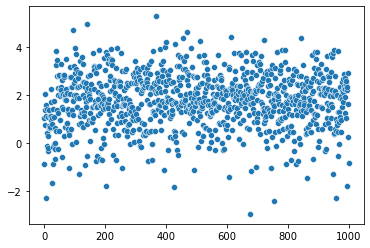

In [133]:
reward_at_time, choice_at_time, estimates = do_run(
    rewards, 
    epsilon=epsilon, 
    num_timesteps=num_timesteps
)

# Note that for a given run, things are quite noisy!
sns.scatterplot(x=np.arange(len(reward_at_time)), y=reward_at_time)

In [134]:
# Do lots of runs and average...
reward_at_times_list = []
for i in range(num_runs):
    reward_at_time, choice_at_time, estimates = do_run(
        rewards,
        epsilon=0.1,
        num_timesteps=num_timesteps
    )
    reward_at_times_list.append(reward_at_time)
reward_at_times = np.vstack(reward_at_times_list)

<AxesSubplot:>

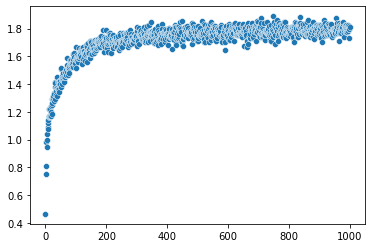

In [135]:
mean_reward_at_times_eps_01 = np.mean(reward_at_times, axis=0)
sns.scatterplot(
    x=np.arange(len(mean_reward_at_times_eps_01)),
    y=mean_reward_at_times_eps_01
)

In [136]:
# Do greedy (epsilon = 0)
reward_at_times_list = []
for i in range(num_runs):
    reward_at_time, choice_at_time, estimates = do_run(
        rewards,
        epsilon=0.0,
        num_timesteps=num_timesteps
    )
    reward_at_times_list.append(reward_at_time)
reward_at_times = np.vstack(reward_at_times_list)
mean_reward_at_times_greedy = np.mean(reward_at_times, axis=0)

In [137]:
reward_at_times_list = []
for i in range(num_runs):
    reward_at_time, choice_at_time, estimates = do_run(
        rewards,
        epsilon=0.01,
        num_timesteps=num_timesteps
    )
    reward_at_times_list.append(reward_at_time)
reward_at_times = np.vstack(reward_at_times_list)
mean_reward_at_times_eps_001 = np.mean(reward_at_times, axis=0)

<AxesSubplot:>

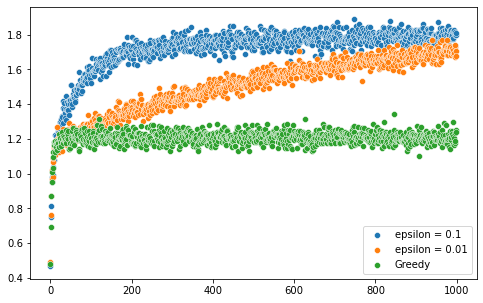

In [138]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
times = np.arange(len(mean_reward_at_times_eps_01))
sns.scatterplot(
    x=times,
    y=mean_reward_at_times_eps_01,
    ax=ax,
    label='epsilon = 0.1'
)
sns.scatterplot(
    x=times,
    y=mean_reward_at_times_eps_001,
    ax=ax,
    label='epsilon = 0.01'
)
sns.scatterplot(
    x=times,
    y=mean_reward_at_times_greedy,
    ax=ax,
    label='Greedy'
)

## Conclusion
So this pretty much reproduces the relevant figure from Sutton & Barto...  Let's move on.  Later on, we should re-factor code so that we can run different policies on the same experiment in a modular fashion!